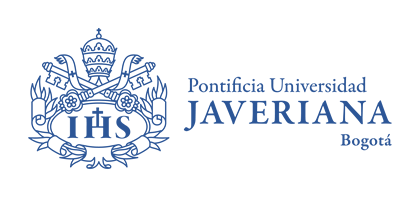

# **Assignment 1**

### **By:**

- Diego Garzón
- Carlos Másmela
- Yudy Pedraza

### **Summary:**

The following notebook has the purpose of train the model t identofy the **penguin specie** according to some features given.


# **Libraries**


In [178]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier

# Save model
import joblib

# **Data Reading**


Let's read penguin data


In [179]:
data = pd.read_csv("../data/penguins_lter.csv")
data.columns = data.columns.str.lower()
data.head()

,species,culmen length (mm),culmen depth (mm),flipper length (mm),body mass (g),sex,delta 15 n (o/oo),delta 13 c (o/oo)
0,Adelie Penguin (Pygoscelis adeliae),39.1,18.7,181.0,3750.0,MALE,NaN,NaN
1,Adelie Penguin (Pygoscelis adeliae),39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454
2,Adelie Penguin (Pygoscelis adeliae),40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302
3,Adelie Penguin (Pygoscelis adeliae),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie Penguin (Pygoscelis adeliae),36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426


# **Data Understanding**


Variable type


In [180]:
data.dtypes

species                 object
culmen length (mm)     float64
culmen depth (mm)      float64
flipper length (mm)    float64
body mass (g)          float64
sex                     object
delta 15 n (o/oo)      float64
delta 13 c (o/oo)      float64
dtype: object

Variable to be predicted distribution


In [181]:
pd.DataFrame(data["species"].value_counts() / len(data))

,count
species,
Adelie Penguin (Pygoscelis adeliae),0.441860
Gentoo penguin (Pygoscelis papua),0.360465
Chinstrap penguin (Pygoscelis antarctica),0.197674


# **Data Preparation**


## _Split Train and Test_


In [182]:
# Division between y and the rest of variables

y = data["species"].map({"Adelie Penguin (Pygoscelis adeliae)": 0, "Chinstrap penguin (Pygoscelis antarctica)": 1, "Gentoo penguin (Pygoscelis papua)": 2})
X = data.drop(columns="species")

# Split train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [183]:
y.unique()

array([0, 1, 2], dtype=int64)

## _Nulls_


Let see the null values


In [184]:
pd.DataFrame(X_train.isna().sum()) / len(X_train)

,0
culmen length (mm),0.003636
culmen depth (mm),0.003636
flipper length (mm),0.003636
body mass (g),0.003636
sex,0.029091
delta 15 n (o/oo),0.040000
delta 13 c (o/oo),0.036364


We see that there are some nulls, we need to treat them


In [185]:
# We look every column type
categorical_columns = X_train.select_dtypes(exclude=[int, float]).columns
numerical_columns = X_train.select_dtypes(include=[int, float]).columns

# Impute variables
categoricas_imputer = SimpleImputer(missing_values=np.nan, strategy="constant")
numericas_imputer = SimpleImputer(missing_values=np.nan, strategy="median")

# Training Imputers
categoricas_imputer.fit(X_train[categorical_columns])
numericas_imputer.fit(X_train[numerical_columns])

# Impute variables
X_train[categorical_columns] = categoricas_imputer.transform(
    X_train[categorical_columns]
)
X_test[categorical_columns] = categoricas_imputer.transform(X_test[categorical_columns])

X_train[numerical_columns] = numericas_imputer.transform(X_train[numerical_columns])
X_test[numerical_columns] = numericas_imputer.transform(X_test[numerical_columns])

Null review after imputing


In [186]:
pd.DataFrame(X_train.isna().sum() / len(X_train))

,0
culmen length (mm),0.0
culmen depth (mm),0.0
flipper length (mm),0.0
body mass (g),0.0
sex,0.0
delta 15 n (o/oo),0.0
delta 13 c (o/oo),0.0


## _Dummies_


Dummy variables for categorical features


In [187]:
categorical_columns = X_train.select_dtypes(exclude=[int, float]).columns
numerical_columns = X_train.select_dtypes(include=[int, float]).columns

X_train = pd.get_dummies(
    X_train, columns=categorical_columns, drop_first=True, dtype=float
)
X_test = pd.get_dummies(
    X_test, columns=categorical_columns, drop_first=True, dtype=float
)

# What the model recieves
print(X_train.shape)
print(X_test.shape)

(275, 8)
(69, 9)


Align same X_train and X_test variables


In [188]:
X_train, X_test = X_train.align(X_test, fill_value=0, axis=1, join="left")

# What the model receives
print(X_train.shape)
print(X_test.shape)

(275, 8)
(69, 8)


## _Data Standarization_


Normalizing data with normal distribution


In [189]:
columns = X_train.columns
scaler = StandardScaler()

scaler.fit(X_train)  # Se realiza el fit con la data de entrenamiento
X_train.values[:] = scaler.transform(X_train)
X_test.values[:] = scaler.transform(X_test)

# **Modeling**


## _Random Forest_


In [190]:
modelo_rf = RandomForestClassifier(n_jobs=-1, max_depth=100)
modelo_rf.fit(X_train, y_train)
y_pred = modelo_rf.predict(X_test)
f_score = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
print(
    f"Modelo obtuvo las siguientes métricas\nF-Score: {f_score}\nAccuracy: {accuracy}"
)

Modelo obtuvo las siguientes métricas
F-Score: 0.15555555555555556
Accuracy: 0.30434782608695654


## _XGBoost_


In [191]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
f_score = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
print(
    f"Modelo obtuvo las siguientes métricas\nF-Score: {f_score}\nAccuracy: {accuracy}"
)

Modelo obtuvo las siguientes métricas
F-Score: 0.21122112211221122
Accuracy: 0.463768115942029


# **Save model**


Random forest


In [192]:
joblib.dump(modelo_rf, "model_random_forest.joblib")

['model_random_forest.joblib']

XGBoost


In [193]:
joblib.dump(xgb, "model_xgb.joblib")

['model_xgb.joblib']